# Task 2

# Task 2: Pre-processing

In [1]:
import re
import pandas as pd
from collections import Counter

# --- Optional: nice progress bars ---
from tqdm.auto import tqdm
tqdm.pandas()


# --- NLP helpers (NLTK) ---
import nltk

# Download required NLTK resources (safe to run multiple times)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------------------------
# 1) Load CSV
# -------------------------
# Update this path to where you saved the Kaggle CSV
CSV_PATH = "imdb.csv"  # e.g. "/mnt/data/IMDB Dataset.csv"

df = pd.read_csv(CSV_PATH)
assert {"review", "sentiment"}.issubset(df.columns), "CSV must have columns: review, sentiment"

print("Rows:", len(df))
print(df.head(3))

Rows: 50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive


In [3]:
# -------------------------
# 2) Basic dataset checks
# -------------------------
print("\nMissing values:\n", df[["review", "sentiment"]].isna().sum())
print("\nDuplicates:", df.duplicated(subset=["review", "sentiment"]).sum())


Missing values:
 review       0
sentiment    0
dtype: int64

Duplicates: 418


In [4]:
# -------------------------
# 3) Cleaning utilities
# -------------------------

_HTML_RE = re.compile(r"<[^>]+>")                      # any HTML tag
_WHITESPACE_RE = re.compile(r"\s+")
_NON_WORD_RE = re.compile(r"[^a-z0-9\s']")             # keep letters, digits, spaces, and apostrophes
_APOSTROPHE_RE = re.compile(r"[’`´]")                  # normalize fancy apostrophes

def remove_html(text: str) -> str:
    """Remove HTML tags like <br />."""
    return _HTML_RE.sub(" ", text)

def normalize_whitespace(text: str) -> str:
    """Collapse whitespace and strip edges."""
    return _WHITESPACE_RE.sub(" ", text).strip()

def basic_clean(text: str) -> str:
    """
    Light cleaning shared across pipelines:
    - remove HTML tags
    - normalize apostrophes
    - normalize whitespace
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)
    text = remove_html(text)
    text = _APOSTROPHE_RE.sub("'", text)
    text = normalize_whitespace(text)
    text = text.lower()
    return text

def classical_clean_for_tokenization(text: str) -> str:
    """
    Classical pipeline cleaning:
    - basic_clean
    - lowercase
    - remove punctuation/symbols (keep letters, digits, spaces)
    """
    text = basic_clean(text)
    text = _NON_WORD_RE.sub(" ", text)
    text = normalize_whitespace(text)
    return text

In [5]:
# -------------------------
# 4) Classical preprocessing pipeline
#    (for n-grams, LSTM/GRU)
# -------------------------

STOPWORDS = set(stopwords.words("english"))
NEGATION_KEEP = {"no", "not", "nor", "never", "none", "n't"}  # keep negation cues

# Remove stopwords but KEEP negations
CLASSICAL_STOPWORDS = STOPWORDS - (NEGATION_KEEP & STOPWORDS)

LEMMATIZER = WordNetLemmatizer()

def transformer_preprocess(text: str) -> str:
    """
    Returns cleaned text for transformer models:
    - HTML removed
    - normalize whitespace
    - normalize apostrophes
    - lowercase
    """
    return basic_clean(text)


def classical_preprocess(text: str,
                         remove_stopwords: bool = False,
                         lemmatize: bool = True,
                         min_token_len: int | None = 2,
                         keep_numbers: bool = True) -> list[str]:
    """
    Returns a list of tokens:
    - HTML removed, lowercase, punctuation removed
    - tokenized
    - optional stopword removal (negations retained)
    - optional lemmatization
    - optional filtering by token length
    """
    # Upstream cleaning (HTML, casing, punctuation) before tokenizing
    text = classical_clean_for_tokenization(text)

    # Tokenize (keep NLTK's tokenizer behavior)
    tokens = word_tokenize(text)

    # Bind locals for speed inside loop
    neg_keep = NEGATION_KEEP
    stop_set = CLASSICAL_STOPWORDS if remove_stopwords else None
    min_len = min_token_len
    keep_nums = keep_numbers
    if lemmatize:
        lem = LEMMATIZER.lemmatize
    
    result: list[str] = []
    for t in tokens:
        # Optionally drop purely numeric tokens
        if not keep_nums and t.isdigit():
            continue

        # Filter short tokens (e.g., 'a', 'i') BUT keep negations
        if min_len is not None and len(t) < min_len and t not in neg_keep:
            continue

        # Stopword removal (negations kept by design)
        if stop_set is not None and t in stop_set:
            continue

        # skip orphan apostrophes
        if t == "'" or t == "''":
            continue

        # Lemmatization (simple noun lemma by default; good enough for this project)
        if lemmatize:
            t = lem(t)

        result.append(t)

    return result

In [6]:
# -------------------------
# 6) Apply pipelines
# -------------------------

apply_fn = df["review"].progress_apply

df["review_clean_transformer"] = apply_fn(transformer_preprocess)
df["tokens_ngram"] = df["review"].progress_apply(
    lambda t: classical_preprocess(
        t,
        remove_stopwords=False,
        lemmatize=True,
        min_token_len=2,
        keep_numbers=True,
    )
)

df["tokens_neural"] = df["review"].progress_apply(
    lambda t: classical_preprocess(
        t,
        remove_stopwords=False,
        lemmatize=False,   
        min_token_len=1,   
        keep_numbers=True,
    )
)



print("\nCreated columns: review_clean_transformer, tokens_ngram, tokens_neural")
print(df[["sentiment", "review_clean_transformer", "tokens_ngram", "tokens_neural"]].head(2))

100%|██████████| 50000/50000 [00:17<00:00, 2833.50it/s]


Created columns: review_clean_transformer, tokens_ngram, tokens_neural
  sentiment                           review_clean_transformer  \
0  positive  one of the other reviewers has mentioned that ...   
1  positive  a wonderful little production. the filming tec...   

                                        tokens_ngram  \
0  [one, of, the, other, reviewer, ha, mentioned,...   
1  [wonderful, little, production, the, filming, ...   

                                       tokens_neural  
0  [one, of, the, other, reviewers, has, mentione...  
1  [a, wonderful, little, production, the, filmin...  


In [7]:
# -------------------------
# 7) Before / After examples (recommended for report)
# -------------------------
def show_examples(n: int = 3, random_state: int = 42):
    sample = df.sample(n=n, random_state=random_state)[["review", "sentiment", "review_clean_transformer", "tokens_ngram", "tokens_neural"]]
    for i, row in enumerate(sample.itertuples(index=False), 1):
        raw, sent, clean_t, tokens_ngram, tokens_neural = row
        print("=" * 90)
        print(f"Example {i} | sentiment={sent}")
        print("\nRAW:\n", raw[:600], "..." if len(raw) > 600 else "")
        print("\nTRANSFORMER (minimal cleaned):\n", clean_t[:600], "..." if len(clean_t) > 600 else "")
        print("\nNGRAM TOKENS (first 80):\n", tokens_ngram[:80])
        print("\nRNN LM TOKENS (first 80):\n", tokens_neural[:80])
        print("Total tokens (ngram):", len(tokens_ngram))
        print("Total tokens (rnn lm):", len(tokens_neural))

show_examples(n=3)

Example 1 | sentiment=positive

RAW:
 I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where  ...

TRANSFORMER (minimal cleaned):
 i really liked this summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. anyways, this could have been one of the best summerslam's ever if the wwf didn't have lex luger in the main event against yokozuna, now for it's time it was ok to have a huge fat man v

In [8]:
# -------------------------
# 8) Quick stats to validate preprocessing (optional but useful)
# -------------------------
df["len_tokens_classical"] = df["tokens_ngram"].apply(len)
print("\nToken length stats (classical):")
print(df["len_tokens_classical"].describe())

print("\nToken length stats by sentiment (classical):")
print(df.groupby("sentiment")["len_tokens_classical"].describe())

# Quick vocabulary size estimate (classical)
# (This can be heavy; sample if needed)
SAMPLE_FOR_VOCAB = 5000
tokens_flat = [t for toks in df["tokens_ngram"].sample(SAMPLE_FOR_VOCAB, random_state=0) for t in toks]
vocabulary = Counter(tokens_flat)
print(f"\nApprox vocab size from {SAMPLE_FOR_VOCAB} samples:", len(vocabulary))
print("Top 20 tokens:", vocabulary.most_common(20))


Token length stats (classical):
count    50000.000000
mean       224.637820
std        167.841772
min          6.000000
25%        122.000000
50%        168.000000
75%        272.000000
max       2399.000000
Name: len_tokens_classical, dtype: float64

Token length stats by sentiment (classical):
             count       mean         std   min    25%    50%    75%     max
sentiment                                                                   
negative   25000.0  222.94208  161.403126   6.0  123.0  168.0  270.0  1497.0
positive   25000.0  226.33356  174.029099  10.0  121.0  167.0  275.0  2399.0

Approx vocab size from 5000 samples: 35700
Top 20 tokens: [('the', 66846), ('and', 32733), ('of', 28739), ('to', 27159), ('is', 21865), ('it', 20806), ('in', 18824), ('this', 15167), ('that', 14784), ("'s", 12279), ('wa', 10327), ('movie', 10306), ('film', 9083), ('a', 8996), ('for', 8972), ('with', 8650), ('but', 8251), ('you', 6998), ('on', 6827), ("n't", 6780)]


# Task 3: Classical Language Modeling

## Task 3.1: N-gram Language Models

In [9]:
# ============================================
# Task 3.1 — N-gram Language Models (Bigram & Trigram)
# ============================================

import math
import random
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

from sklearn.model_selection import train_test_split


# ---------------------------------------------------
# 0) Sanity check: df and tokens_classical
# ---------------------------------------------------
assert "tokens_ngram" in df.columns, "Run Task 2 preprocessing first to create 'tokens_classical'."

# Split reviews into train / test for language modeling
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

train_tokens_list_ngram: List[List[str]] = train_df["tokens_ngram"].tolist()
test_tokens_list_ngram: List[List[str]] = test_df["tokens_ngram"].tolist()

print(f"Train reviews: {len(train_tokens_list_ngram)}, Test reviews: {len(test_tokens_list_ngram)}")


Train reviews: 40000, Test reviews: 10000


In [10]:
# ---------------------------------------------------
# 1) Build vocabulary with <unk>, <s>, </s>
# ---------------------------------------------------

def build_vocab(token_lists: List[List[str]], min_freq: int = 2) -> Dict[str, int]:
    """
    Build a vocabulary from training tokens with frequency >= min_freq.
    Always include special tokens: <unk>, <s>, </s>.
    Return a dict {token: index} (index not used much, but handy).
    """
    counter = Counter()
    for tokens in token_lists:
        counter.update(tokens)

    vocab_tokens = [t for t, c in counter.items() if c >= min_freq]
    vocab_tokens = sorted(vocab_tokens)

    # Add special tokens
    specials = ["<unk>", "<s>", "</s>"]
    vocab_tokens = specials + [t for t in vocab_tokens if t not in specials]

    vocab = {t: i for i, t in enumerate(vocab_tokens)}
    return vocab

vocab = build_vocab(train_tokens_list_ngram, min_freq=2)
print(f"Vocab size (with min_freq=2): {len(vocab)}")
print("First 20 vocab items:", list(vocab.keys())[:20])


def map_tokens_to_vocab(token_lists: List[List[str]], vocab: Dict[str, int]) -> List[List[str]]:
    """
    Replace out-of-vocabulary tokens with <unk>.
    """
    vset = set(vocab.keys())
    mapped = []
    for tokens in token_lists:
        mapped_tokens = [t if t in vset else "<unk>" for t in tokens]
        mapped.append(mapped_tokens)
    return mapped

train_tokens_mapped = map_tokens_to_vocab(train_tokens_list_ngram, vocab)
test_tokens_mapped = map_tokens_to_vocab(test_tokens_list_ngram, vocab)




Vocab size (with min_freq=2): 52962
First 20 vocab items: ['<unk>', '<s>', '</s>', "'00s", "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08", "'10", "'12", "'15", "'1947", "'2001", "'20s", "'24", "'28"]


In [11]:
# ---------------------------------------------------
# 2) Build sentences with start/end symbols
# ---------------------------------------------------

def build_ngram_sentences(
    token_lists: List[List[str]],
    n: int,
    add_start_tokens: bool = True
) -> List[List[str]]:
    """
    Prepare sentences for n-gram modeling:
    - pad with (n-1) <s> tokens at the start (if add_start_tokens)
    - add </s> at the end
    """
    sentences = []
    for tokens in token_lists:
        sent = []
        if add_start_tokens:
            sent.extend(["<s>"] * (n - 1))
        sent.extend(tokens)
        sent.append("</s>")
        sentences.append(sent)
    return sentences

train_sents_bigram = build_ngram_sentences(train_tokens_mapped, n=2)
train_sents_trigram = build_ngram_sentences(train_tokens_mapped, n=3)

test_sents_bigram = build_ngram_sentences(test_tokens_mapped, n=2)
test_sents_trigram = build_ngram_sentences(test_tokens_mapped, n=3)

print("Example bigram sentence:", train_sents_bigram[0][:30])
print("Example trigram sentence:", train_sents_trigram[0][:30])




Example bigram sentence: ['<s>', 'that', "'s", 'what', 'kept', 'asking', 'myself', 'during', 'the', 'many', 'fight', 'screaming', 'match', 'swearing', 'and', 'general', 'mayhem', 'that', 'permeate', 'the', '84', 'minute', 'the', 'comparison', 'also', 'stand', 'up', 'when', 'you', 'think']
Example trigram sentence: ['<s>', '<s>', 'that', "'s", 'what', 'kept', 'asking', 'myself', 'during', 'the', 'many', 'fight', 'screaming', 'match', 'swearing', 'and', 'general', 'mayhem', 'that', 'permeate', 'the', '84', 'minute', 'the', 'comparison', 'also', 'stand', 'up', 'when', 'you']


In [12]:
# ---------------------------------------------------
# 3) N-gram Language Model with Laplace smoothing
# ---------------------------------------------------

class NGramLM:
    def __init__(self, n: int, vocab: Dict[str, int], alpha: float = 1.0):
        """
        n: order of the n-gram (e.g., 2 = bigram, 3 = trigram)
        vocab: mapping token -> index
        alpha: Laplace smoothing parameter
        """
        assert n >= 1
        self.n = n
        self.alpha = alpha
        self.vocab = vocab
        self.V = len(vocab)

        # counts[context][word] = count
        self.counts: Dict[Tuple[str, ...], Dict[str, int]] = defaultdict(lambda: defaultdict(int))
        # total number of times each context appears (for normalization)
        self.context_totals: Dict[Tuple[str, ...], int] = defaultdict(int)

    def fit(self, sentences: List[List[str]]):
        """
        Estimate counts from training sentences.
        Each sentence is a list of tokens (already padded with <s>, </s>).
        """
        for sent in sentences:
            if len(sent) < self.n:
                continue
            for i in range(self.n - 1, len(sent)):
                context = tuple(sent[i - self.n + 1 : i])  # length n-1
                word = sent[i]
                self.counts[context][word] += 1
                self.context_totals[context] += 1

    def prob(self, word: str, context: Tuple[str, ...]) -> float:
        """
        Compute P(word | context) with Laplace smoothing.
        context: tuple of length n-1.
        """
        # Handle unseen word by mapping to <unk> if needed
        if word not in self.vocab:
            word = "<unk>"

        word_count = self.counts[context].get(word, 0)
        total_count = self.context_totals.get(context, 0)
        # Laplace smoothing
        num = word_count + self.alpha
        den = total_count + self.alpha * self.V
        return num / den

    def sentence_log_prob(self, sentence: List[str]) -> float:
        """
        Log probability of a single sentence:
        sentence already padded with (n-1) <s> ... </s>
        """
        log_p = 0.0
        for i in range(self.n - 1, len(sentence)):
            context = tuple(sentence[i - self.n + 1 : i])
            word = sentence[i]
            p = self.prob(word, context)
            log_p += math.log(p + 1e-12)  # avoid log(0)
        return log_p

    def perplexity(self, sentences: List[List[str]]) -> float:
        """
        Perplexity over a list of sentences.
        """
        total_log_prob = 0.0
        total_tokens = 0

        for sent in sentences:
            if len(sent) < self.n:
                continue
            total_log_prob += self.sentence_log_prob(sent)
            total_tokens += len(sent) - (self.n - 1)  # tokens predicted

        # perplexity = exp( - (1/N) * sum log p )
        return math.exp(-total_log_prob / max(total_tokens, 1))

    def generate(self, max_len: int = 30) -> List[str]:
        """
        Generate a text sequence using the model.
        Stops when </s> is generated or max_len is reached.
        """
        vocab_list = list(self.vocab.keys())

        # build initial context of (n-1) <s> tokens
        if self.n == 1:
            context = tuple()
        else:
            context = tuple(["<s>"] * (self.n - 1))

        generated = list(context)

        for _ in range(max_len):
            # compute probability distribution over vocab
            probs = []
            for w in vocab_list:
                p = self.prob(w, context)
                probs.append(p)

            # sample next token
            next_token = random.choices(vocab_list, weights=probs, k=1)[0]
            generated.append(next_token)

            if next_token == "</s>":
                break

            # update context
            if self.n > 1:
                context = tuple(generated[-(self.n - 1) :])

        # remove leading <s> and trailing </s>
        out_tokens = [t for t in generated if t not in {"<s>", "</s>"}]
        return out_tokens




In [13]:
# ---------------------------------------------------
# 4) Train bigram and trigram models
# ---------------------------------------------------

bigram_lm = NGramLM(n=2, vocab=vocab, alpha=1.0)
bigram_lm.fit(train_sents_bigram)

trigram_lm = NGramLM(n=3, vocab=vocab, alpha=1.0)
trigram_lm.fit(train_sents_trigram)

print("Bigram and Trigram models trained.")




Bigram and Trigram models trained.


In [14]:
# ---------------------------------------------------
# 5) Compute perplexity on test set
# ---------------------------------------------------

bigram_pp = bigram_lm.perplexity(test_sents_bigram)
trigram_pp = trigram_lm.perplexity(test_sents_trigram)

print(f"\nPerplexity on test set:")
print(f"  Bigram  (n=2): {bigram_pp:.2f}")
print(f"  Trigram (n=3): {trigram_pp:.2f}")




Perplexity on test set:
  Bigram  (n=2): 1577.68
  Trigram (n=3): 14053.90


In [15]:

# ---------------------------------------------------
# 6) Generate sample texts from each model
# ---------------------------------------------------

def join_tokens(tokens: List[str]) -> str:
    """Simple join with spaces; you can improve spacing if you like."""
    return " ".join(tokens)

print("\n=== Sample generations: Bigram model ===")
for i in range(3):
    gen_tokens = bigram_lm.generate(max_len=30)
    print(f"[Bigram sample {i+1}]:", join_tokens(gen_tokens))

print("\n=== Sample generations: Trigram model ===")
for i in range(3):
    gen_tokens = trigram_lm.generate(max_len=30)
    print(f"[Trigram sample {i+1}]:", join_tokens(gen_tokens))


=== Sample generations: Bigram model ===
[Bigram sample 1]: bricusse modernist ziti faith lapd panzer beef legwarmers rivalled glitch dmv azuma wierd claud yada 'salem motivated popeil exacting jon tonal bronstein aspiration petersburg rothschild cuthbert 119 feck inertia imzadi
[Bigram sample 2]: now maxx valli fulfilled hytner schindler violates seto institute yesilcam telescoping interconnected diferent grope knifed kangwon brogue inhibiting mekum laboeuf trannie handful zd integrates roch barmaid kyun gipdac ringside karloff
[Bigram sample 3]: cavern shakingly ever 'spoil suavity fleetingly beane d'onofrio gurantee squeaking seaquarium hotheaded relive anding aparently quimby 'unknown fightrunner melodramatically pressurized persuasively creation hoisted seijun 'tulip argentine letch shopworn unexpressed flouncy

=== Sample generations: Trigram model ===
[Trigram sample 1]: boaz miming picket zag superimpose decorum technology dyan should't boyce cram 09 breakin hardest unedited d

## Task 3.2: Comparison with a Neural Language Model

In [16]:
# ============================================
# Task 3.2 — Neural Language Model (Embedding + LSTM + Softmax)
# ============================================

import time
import math
from typing import List

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------------------------------------------
# 0) Sanity checks and device
# ---------------------------------------------------
assert "tokens_neural" in df.columns, "Run Task 2 preprocessing first."
assert 'vocab' in globals(), "Run Task 3.1 setup to create 'vocab'."
assert 'train_tokens_mapped' in globals() and 'test_tokens_mapped' in globals(), \
    "Run Task 3.1 mapping (train_tokens_mapped, test_tokens_mapped)."

train_tokens_list_rnn_lm: List[List[str]] = train_df["tokens_neural"].tolist()
test_tokens_list_rnn_lm: List[List[str]] = test_df["tokens_neural"].tolist()
vocab_neural = build_vocab(train_tokens_list_rnn_lm, min_freq=2)
train_tokens_mapped_neural = map_tokens_to_vocab(train_tokens_list_rnn_lm, vocab_neural)
test_tokens_mapped_neural = map_tokens_to_vocab(test_tokens_list_rnn_lm, vocab_neural)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [17]:


# ---------------------------------------------------
# 1) Build neural-LM-specific vocab (add <pad>)
# ---------------------------------------------------

if "<pad>" not in vocab_neural:
    vocab_neural["<pad>"] = len(vocab_neural)

# In case <s>, </s>, <unk> weren't included before (they should be, but just to be safe)
for tok in ["<s>", "</s>", "<unk>"]:
    if tok not in vocab_neural:
        vocab_neural[tok] = len(vocab_neural)

id2token_neural = {i: t for t, i in vocab_neural.items()}

vocab_size = len(vocab_neural)
pad_id = vocab_neural["<pad>"]
unk_id = vocab_neural["<unk>"]
bos_id = vocab_neural["<s>"]
eos_id = vocab_neural["</s>"]

print("Neural LM vocab size:", vocab_size)
print("pad_id:", pad_id, "unk_id:", unk_id, "bos_id:", bos_id, "eos_id:", eos_id)

Neural LM vocab size: 59281
pad_id: 59280 unk_id: 0 bos_id: 1 eos_id: 2


In [18]:


# ---------------------------------------------------
# 2) Convert token lists to ID sequences + add BOS/EOS
# ---------------------------------------------------

def tokens_to_ids(tokens_list: List[List[str]]) -> List[List[int]]:
    all_ids = []
    for toks in tokens_list:
        seq = [bos_id]  # start token
        for t in toks:
            seq.append(vocab_neural.get(t, unk_id))
        seq.append(eos_id)  # end token
        all_ids.append(seq)
    return all_ids

train_ids = tokens_to_ids(train_tokens_mapped)
test_ids = tokens_to_ids(test_tokens_mapped)

print("Example train_ids:", train_ids[0][:20])

Example train_ids: [1, 52824, 1292, 57668, 29661, 4957, 36009, 17455, 52836, 33083, 20487, 46537, 33473, 51672, 4009, 22512, 33651, 52824, 39614, 52836]


In [19]:


# ---------------------------------------------------
# 3) Dataset for LM: (input_seq, target_seq) pairs
# ---------------------------------------------------

class LMSequenceDataset(Dataset):
    """
    Turn a list of token-id sequences into fixed-length
    (input, target) pairs for language modeling.
    - Each sample has length max_seq_len.
    - Input is sequence[:-1], target is sequence[1:].
    - Sequences are split into chunks when longer than max_seq_len+1.
    - Short chunks are padded with <pad>.
    """

    def __init__(self, seqs: List[List[int]], max_seq_len: int = 50, pad_id: int = 0):
        self.max_seq_len = max_seq_len
        self.pad_id = pad_id
        self.samples = []  # list of (input_ids, target_ids)

        for ids in seqs:
            if len(ids) < 2:
                continue
            # Slide over the sequence in chunks of max_seq_len+1 (for input+target)
            start = 0
            while start < len(ids) - 1:
                end = min(start + max_seq_len + 1, len(ids))
                chunk = ids[start:end]
                if len(chunk) < 2:
                    break
                inp = chunk[:-1]
                tgt = chunk[1:]

                # Pad to fixed length
                pad_len = max_seq_len - len(inp)
                if pad_len > 0:
                    inp = inp + [pad_id] * pad_len
                    tgt = tgt + [pad_id] * pad_len

                self.samples.append((inp, tgt))
                start += max_seq_len  # non-overlapping chunks

        print(f"Created {len(self.samples)} samples (max_seq_len={max_seq_len}).")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        inp, tgt = self.samples[idx]
        return torch.tensor(inp, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


# Hyperparameters (you can tune these)
MAX_SEQ_LEN = 40
BATCH_SIZE = 64

train_dataset = LMSequenceDataset(train_ids, max_seq_len=MAX_SEQ_LEN, pad_id=pad_id)
test_dataset = LMSequenceDataset(test_ids, max_seq_len=MAX_SEQ_LEN, pad_id=pad_id)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Created 245143 samples (max_seq_len=40).
Created 61460 samples (max_seq_len=40).


In [20]:


# ---------------------------------------------------
# 4) LSTM Language Model definition
# ---------------------------------------------------

class LSTMLanguageModel(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int = 128,
                 hidden_dim: int = 256,
                 num_layers: int = 1,
                 pad_idx: int = 0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim,
                            hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids, hidden=None):
        """
        input_ids: [batch_size, seq_len]
        returns logits: [batch_size, seq_len, vocab_size]
        """
        emb = self.embedding(input_ids)      # [B, L, E]
        outputs, hidden = self.lstm(emb, hidden)  # outputs: [B, L, H]
        logits = self.fc_out(outputs)        # [B, L, V]
        return logits, hidden


# Instantiate model
EMB_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 1

model = LSTMLanguageModel(
    vocab_size=vocab_size,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    pad_idx=pad_id,
).to(device)

# Loss ignores padding positions
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


LSTMLanguageModel(
  (embedding): Embedding(59281, 128, padding_idx=59280)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc_out): Linear(in_features=256, out_features=59281, bias=True)
)


In [21]:


# ---------------------------------------------------
# 5) Training & evaluation loops (perplexity)
# ---------------------------------------------------

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_tokens = 0

    start_time = time.time()

    for batch_idx, (inp, tgt) in enumerate(dataloader):
        inp = inp.to(device)
        tgt = tgt.to(device)  # [B, L]

        optimizer.zero_grad()
        logits, _ = model(inp)  # logits: [B, L, V]

        # Reshape for CrossEntropy: [B*L, V] vs [B*L]
        B, L, V = logits.size()
        loss = criterion(logits.view(B * L, V), tgt.view(B * L))

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        with torch.no_grad():
            # count non-pad tokens
            non_pad = (tgt != pad_id).sum().item()
            total_loss += loss.item() * non_pad
            total_tokens += non_pad

    elapsed = time.time() - start_time
    avg_loss = total_loss / max(total_tokens, 1)
    ppl = math.exp(avg_loss)
    return avg_loss, ppl, elapsed


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for inp, tgt in dataloader:
            inp = inp.to(device)
            tgt = tgt.to(device)

            logits, _ = model(inp)
            B, L, V = logits.size()
            loss = criterion(logits.view(B * L, V), tgt.view(B * L))

            non_pad = (tgt != pad_id).sum().item()
            total_loss += loss.item() * non_pad
            total_tokens += non_pad

    avg_loss = total_loss / max(total_tokens, 1)
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

In [22]:


# ---------------------------------------------------
# 6) Train for a few epochs and monitor perplexity
# ---------------------------------------------------

EPOCHS = 3  # you can increase to 5–10 if training is fast enough

train_times = []
for epoch in range(1, EPOCHS + 1):
    train_loss, train_ppl, train_time_sec = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_ppl = evaluate(model, test_loader, criterion, device)

    train_times.append(train_time_sec)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f},  Train perplexity: {train_ppl:.2f}, "
          f"Time: {train_time_sec:.1f}s")
    print(f"  Test  loss: {val_loss:.4f},  Test  perplexity: {val_ppl:.2f}")

avg_train_time = sum(train_times) / len(train_times)
print(f"\nAverage training time per epoch: {avg_train_time:.1f} seconds")



Epoch 1/3
  Train loss: 6.1157,  Train perplexity: 452.91, Time: 1675.2s
  Test  loss: 5.7345,  Test  perplexity: 309.37

Epoch 2/3
  Train loss: 5.5767,  Train perplexity: 264.20, Time: 1677.6s
  Test  loss: 5.5338,  Test  perplexity: 253.11

Epoch 3/3
  Train loss: 5.3667,  Train perplexity: 214.16, Time: 1678.2s
  Test  loss: 5.4541,  Test  perplexity: 233.72

Average training time per epoch: 1677.0 seconds


In [23]:
# ---------------------------------------------------
# 7) Text generation with the LSTM LM
# ---------------------------------------------------

import torch.nn.functional as F
import random

def generate_with_lstm(model,
                       max_len: int = 30,
                       temperature: float = 1.0,
                       start_token: str = "<s>") -> List[str]:
    """
    Generate text from the LSTM LM.
    - start_token: starting token (usually <s>)
    - temperature: >1.0 -> more random, <1.0 -> more greedy
    """
    model.eval()
    with torch.no_grad():
        # Initialize input sequence with BOS
        start_id = vocab_neural.get(start_token, bos_id)
        input_ids = torch.tensor([[start_id]], dtype=torch.long).to(device)
        generated_ids = [start_id]
        hidden = None

        for _ in range(max_len):
            logits, hidden = model(input_ids, hidden)       # logits: [1, 1, V]
            logits = logits[:, -1, :] / max(temperature, 1e-6)  # last time step, temp scaling

            probs = F.softmax(logits, dim=-1)               # [1, V]
            next_id = torch.multinomial(probs, num_samples=1).item()

            if next_id == eos_id:
                break

            generated_ids.append(next_id)

            # Next input is the newly generated token
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

        # Convert IDs back to tokens (skip <s>, </s>, <pad>)
        tokens = [
            id2token_neural[i]
            for i in generated_ids
            if id2token_neural[i] not in ("<s>", "</s>", "<pad>")
        ]
        return tokens

def join_tokens(tokens: List[str]) -> str:
    return " ".join(tokens)


print("\n=== Sample generations: LSTM neural language model ===")
for i in range(3):
    gen_tokens = generate_with_lstm(model, max_len=30, temperature=1.0)
    print(f"[LSTM sample {i+1}]:", join_tokens(gen_tokens))



=== Sample generations: LSTM neural language model ===
[LSTM sample 1]: the screenplay is old dutch wa fine ken donald coates the romantic duo have touched me in her assignment his work that if this is written by one of the
[LSTM sample 2]: this horrible movie rated the novelty of the wwi premiere of the group from germany with margaret croc trying to keep my attention title song both of course in this
[LSTM sample 3]: im annoying by such trash by glen the case here is story that possibly supposed to happen dirt film and reality it is so exciting say something we venerate already


# Task 4: Transformer Fine-tuning

In [24]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [25]:
assert "review_clean_transformer" in df.columns, "Run Task 2 first"

# Map labels to 0/1
df_hf = df.copy()
df_hf["label"] = df_hf["sentiment"].map({"negative": 0, "positive": 1})

train_df, temp_df = train_test_split(df_hf, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

hf_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df[["review_clean_transformer", "label"]]),
    "validation": Dataset.from_pandas(val_df[["review_clean_transformer", "label"]]),
    "test": Dataset.from_pandas(test_df[["review_clean_transformer", "label"]]),
})

hf_dataset


DatasetDict({
    train: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__'],
        num_rows: 5000
    })
})

In [26]:
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [27]:
# MiniLM: small BERT-like model with WordPiece tokenization
model_name_minilm = "microsoft/MiniLM-L12-H384-uncased"

tokenizer_minilm = AutoTokenizer.from_pretrained(model_name_minilm)

MAX_LENGTH = 256  

def tokenize_minilm(batch):
    return tokenizer_minilm(
        batch["review_clean_transformer"],
        truncation=True,        # cut off longer sequences
        max_length=MAX_LENGTH,  # hard cap at 256
        padding=False           # let DataCollatorWithPadding handle dynamic padding
    )


tokenized_minilm = hf_dataset.map(tokenize_minilm, batched=True)
tokenized_minilm


Map: 100%|██████████| 5000/5000 [00:00<00:00, 10633.80 examples/s]


DatasetDict({
    train: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [28]:
data_collator_minilm = DataCollatorWithPadding(tokenizer=tokenizer_minilm)

model_minilm = AutoModelForSequenceClassification.from_pretrained(
    model_name_minilm,
    num_labels=2
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# use only 8k for training, 2k for validation
train_small_minilm = tokenized_minilm["train"].shuffle(seed=42).select(range(8000))
val_small_minilm   = tokenized_minilm["validation"].shuffle(seed=42).select(range(2000))

In [30]:
training_args_minilm = TrainingArguments(
    output_dir="./minilm_sentiment",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,        # you can increase to 3–4 if you have GPU
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=False,  # simple setup
)

trainer_minilm = Trainer(
    model=model_minilm,
    args=training_args_minilm,
    train_dataset=train_small_minilm,
    eval_dataset=val_small_minilm,
    tokenizer=tokenizer_minilm,
    data_collator=data_collator_minilm,
    compute_metrics=compute_metrics,
)


/var/folders/nv/z73q9gjn4cj9r9b660mdfdf40000gn/T/ipykernel_91026/3753710486.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_minilm = Trainer(


In [31]:
train_result_minilm = trainer_minilm.train()
eval_minilm_val = trainer_minilm.evaluate()

print("MiniLM (validation) metrics:")
print(eval_minilm_val)


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.251700,0.314959,0.880000,0.879168
2,0.178400,0.250029,0.913500,0.913486
3,0.162300,0.266863,0.917000,0.916952


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


MiniLM (validation) metrics:
{'eval_loss': 0.2668634057044983, 'eval_accuracy': 0.917, 'eval_f1': 0.9169521644467213, 'eval_runtime': 13.198, 'eval_samples_per_second': 151.538, 'eval_steps_per_second': 4.773, 'epoch': 3.0}


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


MiniLM Test Accuracy: {'accuracy': 0.9068}
MiniLM Test Macro-F1: {'f1': 0.9067515257131267}

=== Confusion Matrix (Text) ===
                       Predicted Negative   Predicted Positive
Actual Negative                      2210                  252
Actual Positive                       214                 2324


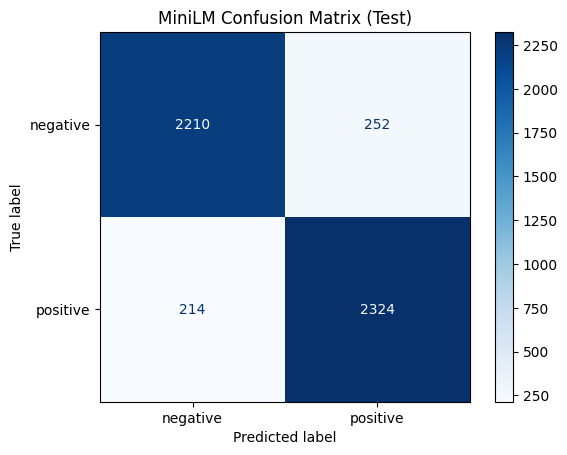

In [32]:
pred_test_minilm = trainer_minilm.predict(tokenized_minilm["test"])
logits_test_minilm = pred_test_minilm.predictions
labels_test_minilm = pred_test_minilm.label_ids
pred_labels_minilm = logits_test_minilm.argmax(axis=-1)

acc_test_minilm = metric_acc.compute(predictions=pred_labels_minilm, references=labels_test_minilm)
f1_test_minilm = metric_f1.compute(predictions=pred_labels_minilm, references=labels_test_minilm, average="macro")

print("MiniLM Test Accuracy:", acc_test_minilm)
print("MiniLM Test Macro-F1:", f1_test_minilm)

cm_minilm = confusion_matrix(labels_test_minilm, pred_labels_minilm)

print("\n=== Confusion Matrix (Text) ===")
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print(f"{'Actual Negative':20} {cm_minilm[0, 0]:>20} {cm_minilm[0, 1]:>20}")
print(f"{'Actual Positive':20} {cm_minilm[1, 0]:>20} {cm_minilm[1, 1]:>20}")

disp_minilm = ConfusionMatrixDisplay(confusion_matrix=cm_minilm, display_labels=["negative", "positive"])
disp_minilm.plot(cmap="Blues")
plt.title("MiniLM Confusion Matrix (Test)")
plt.show()


In [33]:
model_name_bpe = "distilroberta-base"

tokenizer_bpe = AutoTokenizer.from_pretrained(model_name_bpe)


def tokenize_bpe(batch):
    return tokenizer_bpe(
        batch["review_clean_transformer"],
        truncation=True,
        padding="max_length",   # or "longest" if you prefer dynamic padding
        max_length=MAX_LENGTH,
    )

tokenized_bpe = hf_dataset.map(tokenize_bpe, batched=True)

tokenized_bpe


Map: 100%|██████████| 5000/5000 [00:00<00:00, 8169.71 examples/s]


DatasetDict({
    train: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_clean_transformer', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [34]:
# Remove the original text column(s) so Trainer only sees tensors + labels
tokenized_bpe = tokenized_bpe.remove_columns(["review_clean_transformer"])

# Make sure labels are called "labels" for Trainer
tokenized_bpe = tokenized_bpe.rename_column("label", "labels")

# Set to torch format
tokenized_bpe.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [35]:
train_small_bpe = tokenized_bpe["train"].shuffle(seed=42).select(range(8000))
val_small_bpe   = tokenized_bpe["validation"].shuffle(seed=42).select(range(2000))


In [36]:
num_labels = 2  # binary sentiment
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

model_bpe = AutoModelForSequenceClassification.from_pretrained(
    model_name_bpe,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args_bpe = TrainingArguments(
    output_dir="./distilroberta_sentiment",
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    seed=42,
)

trainer_bpe = Trainer(
    model=model_bpe,
    args=training_args_bpe,
    train_dataset=train_small_bpe,
    eval_dataset=val_small_bpe,
    tokenizer=tokenizer_bpe,
    compute_metrics=compute_metrics,
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/nv/z73q9gjn4cj9r9b660mdfdf40000gn/T/ipykernel_91026/1590910999.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bpe = Trainer(


In [37]:
train_result_bpe = trainer_bpe.train()
eval_bpe_val = trainer_bpe.evaluate()

print("DistilRoBERTa (validation) metrics:")
print(eval_bpe_val)

/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.235700,0.239735,0.909500,0.909278
2,0.162100,0.265694,0.928500,0.928500
3,0.129900,0.296287,0.928000,0.927977


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


DistilRoBERTa (validation) metrics:
{'eval_loss': 0.26569420099258423, 'eval_accuracy': 0.9285, 'eval_f1': 0.928499553122207, 'eval_runtime': 14.6647, 'eval_samples_per_second': 136.382, 'eval_steps_per_second': 4.296, 'epoch': 3.0}


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


DistilRoBERTa Test Accuracy: {'accuracy': 0.916}
DistilRoBERTa Test Macro-F1: {'f1': 0.9159977285785807}

=== Confusion Matrix (Text) ===
                       Predicted Negative   Predicted Positive
Actual Negative                      2277                  185
Actual Positive                       235                 2303


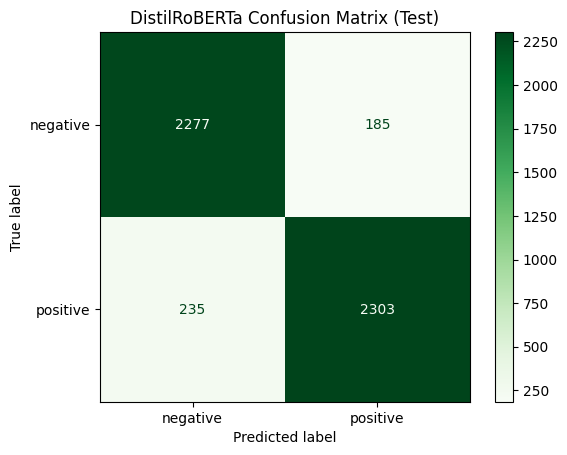

In [38]:
pred_test_bpe = trainer_bpe.predict(tokenized_bpe["test"])
logits_test_bpe = pred_test_bpe.predictions
labels_test_bpe = pred_test_bpe.label_ids
pred_labels_bpe = logits_test_bpe.argmax(axis=-1)

acc_test_bpe = metric_acc.compute(predictions=pred_labels_bpe, references=labels_test_bpe)
f1_test_bpe = metric_f1.compute(predictions=pred_labels_bpe, references=labels_test_bpe, average="macro")

print("DistilRoBERTa Test Accuracy:", acc_test_bpe)
print("DistilRoBERTa Test Macro-F1:", f1_test_bpe)
cm_bpe = confusion_matrix(labels_test_bpe, pred_labels_bpe)

print("\n=== Confusion Matrix (Text) ===")
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print(f"{'Actual Negative':20} {cm_bpe[0, 0]:>20} {cm_bpe[0, 1]:>20}")
print(f"{'Actual Positive':20} {cm_bpe[1, 0]:>20} {cm_bpe[1, 1]:>20}")

disp_bpe = ConfusionMatrixDisplay(confusion_matrix=cm_bpe, display_labels=["negative", "positive"])
disp_bpe.plot(cmap="Greens")
plt.title("DistilRoBERTa Confusion Matrix (Test)")
plt.show()


In [39]:
import torch
import torch.nn.functional as F

# Label id ↔ name mapping
id2label = {0: "negative", 1: "positive"}

def show_minilm_predictions(
    num_examples: int = 5,
    split: str = "test",
    max_review_chars: int = 300,
):
    """
    Print a few test reviews with:
    - gold label
    - predicted label
    - prediction probability
    """
    # HuggingFace test datasets
    ds_text = hf_dataset[split]          # original text + labels
    ds_tok  = tokenized_minilm[split]    # tokenized for MiniLM

    # Take first `num_examples` (or sample randomly if you prefer)
    indices = list(range(min(num_examples, len(ds_tok))))
    small_tok_ds = ds_tok.select(indices)

    # Use Trainer to predict on this small subset
    preds = trainer_minilm.predict(small_tok_ds)
    logits = preds.predictions           # shape (N, 2) for binary classification
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()

    for i, idx in enumerate(indices):
        ex = ds_text[idx]
        text = ex["review_clean_transformer"]
        gold = id2label[ex["label"]]
        pred_id = int(probs[i].argmax())
        pred_label = id2label[pred_id]
        pred_prob = float(probs[i][pred_id])

        print("=" * 100)
        print(f"Example {i+1} (index={idx})")
        print(f"Gold label      : {gold}")
        print(f"Predicted label : {pred_label}  (p = {pred_prob:.3f})")
        print("-" * 100)
        # Show truncated text for readability
        if len(text) > max_review_chars:
            print(text[:max_review_chars] + "...")
        else:
            print(text)
        print()  # blank line

show_minilm_predictions(num_examples=5)


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Example 1 (index=0)
Gold label      : negative
Predicted label : negative  (p = 0.987)
----------------------------------------------------------------------------------------------------
the tortuous emotional impact is degrading, whether adult or adolescent the personal values shown in this movie belong in a bad psychodrama if anywhere at all. this movie has a plot, but it is all evil from start to end. this is no way for people to act and degrades both sexes all the way through th...

Example 2 (index=1)
Gold label      : negative
Predicted label : negative  (p = 0.985)
----------------------------------------------------------------------------------------------------
anyone who knows anything about evolution wouldn't even need to see the film to say "fake". "it's never been disproved" also is a weak argument. saying the universe was created by a giant hippo cannot be disproved. although, to be fair, it does seem like the only people who do believe are the same p...

Example 3 (ind

## Task 4: Model Evaluation & Benchmarking

In [40]:
import random

N_SAMPLE = 100
SEED = 42

random.seed(SEED)
indices_100 = random.sample(range(len(hf_dataset["test"])), k=N_SAMPLE)

sample_text_ds = hf_dataset["test"].select(indices_100)          # original text + gold labels
sample_tok_ds   = tokenized_minilm["test"].select(indices_100)   # tokenized for MiniLM

len(sample_text_ds), len(sample_tok_ds)


(100, 100)

In [41]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Run MiniLM on the 100-tokenized samples
preds_100 = trainer_minilm.predict(sample_tok_ds)
logits_100 = preds_100.predictions
labels_100 = preds_100.label_ids
probs_100 = F.softmax(torch.tensor(logits_100), dim=-1).numpy()
pred_labels_100 = probs_100.argmax(axis=-1)

acc_100 = accuracy_score(labels_100, pred_labels_100)
f1_100 = f1_score(labels_100, pred_labels_100, average="macro")

print(f"MiniLM on 100-sample subset:")
print(f"  Accuracy:   {acc_100:.3f}")
print(f"  Macro-F1:   {f1_100:.3f}")


/Users/I747530/Documents/NLP_project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


MiniLM on 100-sample subset:
  Accuracy:   0.860
  Macro-F1:   0.858


In [42]:
# Use your classical pipeline tokenizer (or a light version) to get tokens
def simple_classical_tokens(text: str):
    # If you have classical_preprocess, you can call it directly.
    # Here we assume df['tokens_classical'] is only for the original splits,
    # so we'll just reuse your cleaning logic:
    from nltk.tokenize import word_tokenize
    text_clean = classical_clean_for_tokenization(text)
    return word_tokenize(text_clean)

# Convert the 100 HF test texts into token lists
sample_tokens_100 = [
    simple_classical_tokens(x["review_clean_transformer"])
    for x in sample_text_ds
]

# Map tokens to vocab (same as before)
sample_tokens_mapped_100 = map_tokens_to_vocab(sample_tokens_100, vocab)

# Build padded sentences for bigram/trigram
sample_sents_bigram_100  = build_ngram_sentences(sample_tokens_mapped_100, n=2)
sample_sents_trigram_100 = build_ngram_sentences(sample_tokens_mapped_100, n=3)

# Compute perplexity
pp_bigram_100  = bigram_lm.perplexity(sample_sents_bigram_100)
pp_trigram_100 = trigram_lm.perplexity(sample_sents_trigram_100)



In [43]:

# 2) LSTM LM perplexity on the same 100 texts
#    (mirror the tokens_neural pipeline)
# ------------------------------------------------------

# Tokenization that matches how you built tokens_neural:
#   remove_stopwords=False, lemmatize=False, min_token_len=1, keep_numbers=True
sample_tokens_neural_100 = [
    classical_preprocess(
        x["review_clean_transformer"],
        remove_stopwords=False,
        lemmatize=False,
        min_token_len=1,
        keep_numbers=True,
    )
    for x in sample_text_ds
]

# Convert to ID sequences with BOS/EOS using the neural LM vocab
sample_ids_100 = tokens_to_ids(sample_tokens_neural_100)

# Build a small dataset + dataloader for the LSTM LM
sample_dataset_lstm_100 = LMSequenceDataset(
    sample_ids_100,
    max_seq_len=MAX_SEQ_LEN,
    pad_id=pad_id,
)
sample_loader_lstm_100 = DataLoader(
    sample_dataset_lstm_100,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Evaluate LSTM LM on this 100-sample subset
_, pp_lstm_100 = evaluate(model, sample_loader_lstm_100, criterion, device)


Created 635 samples (max_seq_len=40).


TypeError: 'module' object is not callable

In [ ]:
# 3) Print comparison
# ------------------------------------------------------
print("\n=== Perplexity Comparison (100-sample subset) ===")
print(f"Bigram LM    : {pp_bigram_100:.1f}")
print(f"Trigram LM   : {pp_trigram_100:.1f}")
print(f"LSTM neural LM: {pp_lstm_100:.1f}")



=== Perplexity Comparison (100-sample subset) ===
Bigram LM    : 1680.0
Trigram LM   : 16793.7
LSTM neural LM: 59621.9


In [ ]:

# Build a DataFrame with text, gold label, model prediction & prob
id2label = {0: "negative", 1: "positive"}

rows = []
for i, ex in enumerate(sample_text_ds):
    text = ex["review_clean_transformer"]
    gold = id2label[ex["label"]]
    pred_id = int(pred_labels_100[i])
    pred_label = id2label[pred_id]
    pred_prob = float(probs_100[i, pred_id])

    rows.append({
        "sample_index": indices_100[i],
        "text": text,
        "gold_label": gold,
        "model_label": pred_label,
        "model_confidence": pred_prob,
        # columns for human annotators to fill in:
        "human_label_annotator1": "",
        "human_label_annotator2": "",
        "human_confidence_annotator1": "",
        "human_confidence_annotator2": "",
    })

df_100 = pd.DataFrame(rows)
df_100.to_csv("human_eval_100.csv", index=False)

df_100.head()


,sample_index,text,gold_label,model_label,model_confidence,human_label_annotator1,human_label_annotator2,human_confidence_annotator1,human_confidence_annotator2
0,912,....this mini does not get better with age. i ...,negative,negative,0.949876,,,,
1,204,this documentary is the most hypnotizing film ...,positive,positive,0.991690,,,,
2,2253,"all dogs go to heaven is, in my opinion, the b...",positive,positive,0.991721,,,,
3,2006,rosalind russell executes a power-house perfor...,positive,positive,0.991397,,,,
4,1828,this film screened last night at austin's para...,positive,positive,0.991677,,,,


In [ ]:
df_annotated = pd.read_csv("human_eval_100.annotated.csv")

# Convert human labels to ids (e.g. using annotator 1)
label2id = {"negative": 0, "positive": 1}

human_labels_1 = df_annotated["human_label_annotator1"].map(label2id)
gold_labels = df_annotated["gold_label"].map(label2id)
model_labels = df_annotated["model_label"].map(label2id)

# Human vs gold
acc_human_vs_gold = accuracy_score(gold_labels, human_labels_1)
f1_human_vs_gold = f1_score(gold_labels, human_labels_1, average="macro")

# Model vs gold (should match acc_100/f1_100)
acc_model_vs_gold = accuracy_score(gold_labels, model_labels)
f1_model_vs_gold = f1_score(gold_labels, model_labels, average="macro")

# Agreement between human and model
acc_model_vs_human = accuracy_score(human_labels_1, model_labels)
f1_model_vs_human = f1_score(human_labels_1, model_labels, average="macro")

print("Human vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_human_vs_gold, f1_human_vs_gold))
print("Model vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_model_vs_gold, f1_model_vs_gold))
print("Model vs human:  acc={:.3f}, macro-F1={:.3f}".format(acc_model_vs_human, f1_model_vs_human))


Human vs gold:   acc=0.940, macro-F1=0.939
Model vs gold:   acc=0.860, macro-F1=0.858
Model vs human:  acc=0.860, macro-F1=0.858


In [ ]:
disagree_idx = df_annotated[gold_labels != human_labels_1].index
df_annotated.loc[disagree_idx, ["text", "gold_label", "human_label_annotator1", "model_label"]].head()


,text,gold_label,human_label_annotator1,model_label
10,I raced to the library to check out this minis...,positive,negative,positive
17,Average adventure movie that took a serious st...,positive,negative,positive
30,That is the answer. The question is: What is t...,negative,positive,positive
31,"If anything, William Girdler was an opportunis...",positive,negative,positive
50,"This movie certainly proves, that also the goo...",negative,positive,positive


In [ ]:
judge_rows = []
for i, row in df_100.iterrows():
    text = row["text"]
    model_label = row["model_label"]

    prompt = f"""
You are a strict sentiment annotator.

Read the following movie review and then answer with a single word:
either "positive" or "negative".

Review:
{text}

What is the correct overall sentiment of this review? Answer with only one word: positive or negative.
    """.strip()

    judge_rows.append({
        "sample_index": row["sample_index"],
        "text": text,
        "gold_label": row["gold_label"],
        "model_label": model_label,
        "judge_prompt": prompt,
        "judge_label": ""  # to fill with LLM output
    })

df_judge = pd.DataFrame(judge_rows)
df_judge.to_csv("llm_judge_100_template.csv", index=False)
df_judge.head()


,sample_index,text,gold_label,model_label,judge_prompt,judge_label
0,912,....this mini does not get better with age. i ...,negative,negative,You are a strict sentiment annotator.\n\nRead ...,
1,204,this documentary is the most hypnotizing film ...,positive,positive,You are a strict sentiment annotator.\n\nRead ...,
2,2253,"all dogs go to heaven is, in my opinion, the b...",positive,positive,You are a strict sentiment annotator.\n\nRead ...,
3,2006,rosalind russell executes a power-house perfor...,positive,positive,You are a strict sentiment annotator.\n\nRead ...,
4,1828,this film screened last night at austin's para...,positive,positive,You are a strict sentiment annotator.\n\nRead ...,


In [ ]:
import pandas as pd
import ollama  # pip install ollama

# Name of your locally available Ollama model
# e.g. "llama3.2:latest", "llama3.2:1b-instruct", "mistral:latest", etc.
JUDGE_MODEL_NAME = "llama3.2:latest"

df_judge = pd.read_csv("llm_judge_100_template.csv")

def ask_ollama(prompt: str, model: str, max_tokens: int = 10) -> str:
    """
    Call Ollama's /chat endpoint via the Python client.
    Returns the model's text response.
    """
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "user", "content": prompt}
        ],
        options={
            "num_predict": max_tokens,
            "temperature": 0.0,  # deterministic, similar to do_sample=False
        },
    )
    # For chat, the text is in response["message"]["content"]
    return response["message"]["content"]

def extract_label_from_response(text: str) -> str:
    text_low = text.lower()
    if "positive" in text_low and "negative" not in text_low:
        return "positive"
    if "negative" in text_low and "positive" not in text_low:
        return "negative"
    # fallback (you can improve this)
    return "positive" if "positive" in text_low else "negative"

judge_labels = []
for prompt in df_judge["judge_prompt"]:
    out = ask_ollama(prompt, JUDGE_MODEL_NAME, max_tokens=10)
    label = extract_label_from_response(out)
    judge_labels.append(label)

df_judge["judge_label"] = judge_labels
df_judge.to_csv("llm_judge_100_annotated.csv", index=False)

print("Saved to llm_judge_100_annotated.csv")


Saved to llm_judge_100_annotated.csv


In [ ]:
df_judge_annotated = pd.read_csv("llm_judge_100_annotated.csv")

judge_labels = df_judge_annotated["judge_label"].map(label2id)
gold_labels  = df_judge_annotated["gold_label"].map(label2id)
model_labels = df_judge_annotated["model_label"].map(label2id)

# Judge vs gold
acc_judge_vs_gold = accuracy_score(gold_labels, judge_labels)
f1_judge_vs_gold = f1_score(gold_labels, judge_labels, average="macro")

# Judge vs model
acc_judge_vs_model = accuracy_score(model_labels, judge_labels)
f1_judge_vs_model = f1_score(model_labels, judge_labels, average="macro")

print("LLM-judge vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_judge_vs_gold, f1_judge_vs_gold))
print("LLM-judge vs model:  acc={:.3f}, macro-F1={:.3f}".format(acc_judge_vs_model, f1_judge_vs_model))


LLM-judge vs gold:   acc=0.920, macro-F1=0.920
LLM-judge vs model:  acc=0.840, macro-F1=0.840
